In [ ]:
from google.colab import drive

# Monta o Google Drive no Colab
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re
import pandas as pd

from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
file_path = '/content/drive/MyDrive/TCC/datasets/dataset_filtered_youtube.csv'

# Lê o arquivo CSV do Google Drive para um DataFrame do Pandas
df = pd.read_csv(file_path)

In [ ]:
df.head()

,channel_id,author_id,message_data,message_utc,window_id,message_length,domain
0,-1001034598292,126906048.0,https://www.youtube.com/watch?v=S265ilIKldk,2020-03-05 15:17:36,1,43,youtube
1,-1001034598292,126906048.0,e saiu o gameplay de final fantasy 7 galera,2020-03-05 15:17:35,1,43,youtube
2,-1001034598292,126906048.0,xfce é só amor,2020-03-05 15:17:24,1,14,youtube
3,-1001034598292,126906048.0,Gnome também é,2020-03-05 15:17:20,1,14,youtube
4,-1001034598292,126906048.0,Plasma é bom =D,2020-03-05 15:17:13,1,15,youtube


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Funções para remover ruído
# Remove tags HTML
def clean_html(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

# Converte para minúsculas
def to_lower_case(text):
    return text.lower()

# Remove RT (Retweet)
def remove_retweet(text):
    # Divide as palavras no texto
    words = text.split()
    # Remove palavras contendo "RT"
    words_without_rt = [word for word in words if "RT" not in word]
    # Junta as palavras novamente
    result = " ".join(words_without_rt)
    return result

# Remove URLs iniciadas com "https"
def remove_https(text):
    # Divide as palavras no texto
    words = text.split()
    # Remove palavras contendo "https"
    words_without_https = [word for word in words if "https" not in word]
    # Junta as palavras novamente
    result = " ".join(words_without_https)
    return result

# Remove menções de usuários em tweets
def remove_tweet_mentions(text):
    # Divide as palavras no texto
    words = text.split()
    # Remove palavras contendo "@"
    words_without_mentions = [word for word in words if "@" not in word]
    # Junta as palavras novamente
    result = " ".join(words_without_mentions)
    return result

def remove_special_characters(text):
    # Mantém apenas letras, números e espaços
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return cleaned_text

# Remove ruído (combina as funções acima)
def remove_noise(text):
    if isinstance(text, str):
        text = remove_https(text)
        text = remove_retweet(text)
        text = clean_html(text)
        text = to_lower_case(text)
        text = remove_tweet_mentions(text)
        text = remove_special_characters(text)
        return text
    else:
        return text

In [ ]:
# Lê csv de mensagens já classificadas que serão usados para treinar o modelo
url = 'https://raw.githubusercontent.com/victoriasaliba/tp_final_ML/main/Tweets_Mg.csv'

# Ler o arquivo CSV
df_categorized = pd.read_csv(url)

df_categorized.Text = df_categorized.Text.apply(remove_noise)

In [ ]:
df_categorized.head()

,Unnamed: 0,Created At,Text,Geo Coordinates.latitude,Geo Coordinates.longitude,User Location,Username,User Screen Name,Retweet Count,Classificacao,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,0,Sun Jan 08 01:22:05 +0000 2017,catedral de santo antnio governador valadaresmg,NaN,NaN,Brasil,Leonardo C Schneider,LeoCSchneider,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Sun Jan 08 01:49:01 +0000 2017,governador valadares minas gerais,-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Sun Jan 08 01:01:46 +0000 2017,governador valadares minas gerais,-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Wed Jan 04 21:43:51 +0000 2017,,NaN,NaN,NaN,Ana estudando,estudandoconcur,0,Neutro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Mon Jan 09 15:08:21 +0000 2017,psol vai questionar aumento de vereadores e p...,NaN,NaN,NaN,Emily,Milly777,0,Negativo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
len(df_categorized)

8199

In [ ]:
# Separar os textos e os rótulos
x = df_categorized['Text']
y = df_categorized['Classificacao']

# Dividir os dados em conjuntos de treinamento e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

# Vetorização dos textos usando CountVectorizer
vectorizer = CountVectorizer()
x_train_vec = vectorizer.fit_transform(x_train.values.astype('U'))
x_test_vec = vectorizer.transform(x_test.values.astype('U'))

# Treinar o modelo Naive Bayes
model = MultinomialNB()
model.fit(x_train_vec, y_train)

# Fazer previsões no conjunto de teste
y_pred = model.predict(x_test_vec)

# Avaliar a precisão do modelo
accuracy = accuracy_score(y_test, y_pred)
print('Acurácia do modelo: {:.2f}%'.format(accuracy * 100))

Acurácia do modelo: 95.00%


In [ ]:
confusion_matrix = confusion_matrix(y_test, y_pred)

# Extrair os valores da matriz de confusão
TP = confusion_matrix[1, 1]  # True Positives
FN = confusion_matrix[1, 0]  # False Negatives

# Calcular o recall
recall = TP / (TP + FN)

In [ ]:
print(recall)

0.9585921325051759


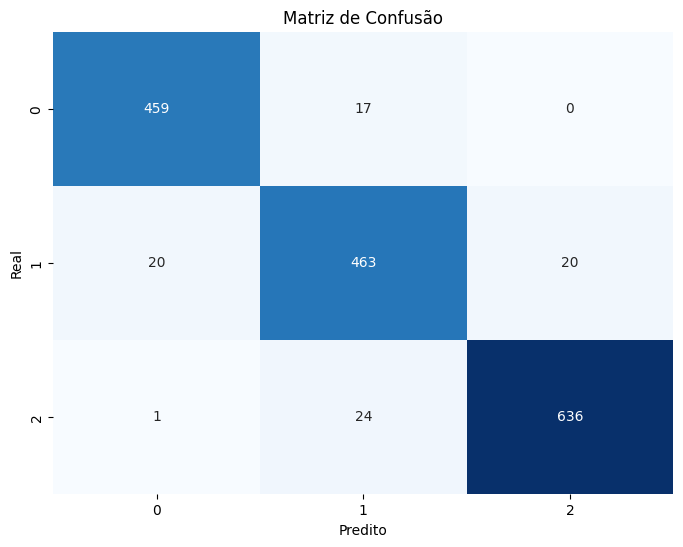


Relatório de Classificação:
               precision    recall  f1-score   support

    Negativo       0.96      0.96      0.96       476
      Neutro       0.92      0.92      0.92       503
    Positivo       0.97      0.96      0.97       661

    accuracy                           0.95      1640
   macro avg       0.95      0.95      0.95      1640
weighted avg       0.95      0.95      0.95      1640



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(y_test, y_pred)

# Exiba a matriz de confusão usando seaborn
plt.figure(figsize = (8, 6))
sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "Blues", cbar = False)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

# Exiba o relatório de classificação
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))

O modelo apresenta um desempenho geral muito bom, com alta precisão, revocação e F1-Score para cada classe. A acurácia global de 0.95 indica que o modelo está acertando a classificação em 95% das instâncias.

In [ ]:
def plot_feelings_per_date(df):
    df['message_utc'] = pd.to_datetime(df['message_utc'])
    count_feelings = df.groupby(['message_utc', 'predicted_feeling']).size().unstack(fill_value=0)

    count_feelings['total_positives'] = count_feelings['Positivo'].groupby('message_utc').cumsum()
    count_feelings['total_negatives'] = count_feelings['Negativo'].groupby('message_utc').cumsum()

    sns.set(style = "whitegrid")
    plt.figure(figsize = (12, 6))

    count_feelings['message_data'] = pd.to_datetime(count_feelings.index)

    sns.lineplot(data = count_feelings, x = 'message_data', y = 'total_positives', label = 'Positivos')
    sns.lineplot(data = count_feelings, x = 'message_data', y = 'total_negatives', label = 'Negativos')

    plt.title('Análise Temporal dos Sentimentos')
    plt.xlabel('Data')
    plt.ylabel('Total Diário')
    plt.xticks(rotation = 45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
data_test_youtube = df

data_test_youtube['message_data'] = data_test_youtube['message_data'].apply(remove_noise)

# Remover linhas com valores nulos em 'message_data'
data_test_youtube = data_test_youtube.dropna(subset = ['message_data'])

# Vetorizar os textos
x_test_youtube = vectorizer.transform(data_test_youtube['message_data'].values.astype('U'))

# Fazer previsões no conjunto de teste
y_pred_youtube = model.predict(x_test_youtube)

# Atribuir as previsões ao DataFrame
data_test_youtube['predicted_feeling'] = y_pred_youtube

<ipython-input-15-d5e2cc3675c3>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_youtube['predicted_feeling'] = y_pred_youtube


In [ ]:
print(data_test_youtube)

           channel_id     author_id  \
0      -1001034598292  1.269060e+08   
1      -1001034598292  1.269060e+08   
2      -1001034598292  1.269060e+08   
3      -1001034598292  1.269060e+08   
4      -1001034598292  1.269060e+08   
...               ...           ...   
480183 -1001425869380  1.013817e+09   
480184 -1001425869380  1.013817e+09   
480185 -1001425869380  1.013817e+09   
480186 -1001425869380  1.013817e+09   
480187 -1001425869380  1.013817e+09   

                                             message_data  \
0                                                           
1             e saiu o gameplay de final fantasy 7 galera   
2                                            xfce  s amor   
3                                            gnome tambm    
4                                           plasma  bom d   
...                                                   ...   
480183  issingballotsbutdoesnthaveanyadditionalinforma...   
480184  lista de fraudes chovem denncias de

In [ ]:
# Conta a quantidade de ocorrências de cada sentimento
count_feelings = data_test_youtube['predicted_feeling'].value_counts()
print(count_feelings)

# Calcula a proporção de sentimentos positivos e negativos
neutral_proportion = count_feelings[0] / len(data_test_youtube)
positive_proportion = count_feelings[1] / len(data_test_youtube)
negative_proportion = count_feelings[2] / len(data_test_youtube)

# Exibe as proporções
print('Proporção de sentimentos positivos: {:.2f}%'.format(positive_proportion * 100))
print('Proporção de sentimentos neutros: {:.2f}%'.format(neutral_proportion * 100))
print('Proporção de sentimentos negativos: {:.2f}%'.format(negative_proportion * 100))

Neutro      213873
Positivo    195891
Negativo     29105
Name: predicted_feeling, dtype: int64
Proporção de sentimentos positivos: 44.64%
Proporção de sentimentos neutros: 48.73%
Proporção de sentimentos negativos: 6.63%


<ipython-input-14-e808a17642f5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['message_utc'] = pd.to_datetime(df['message_utc'])


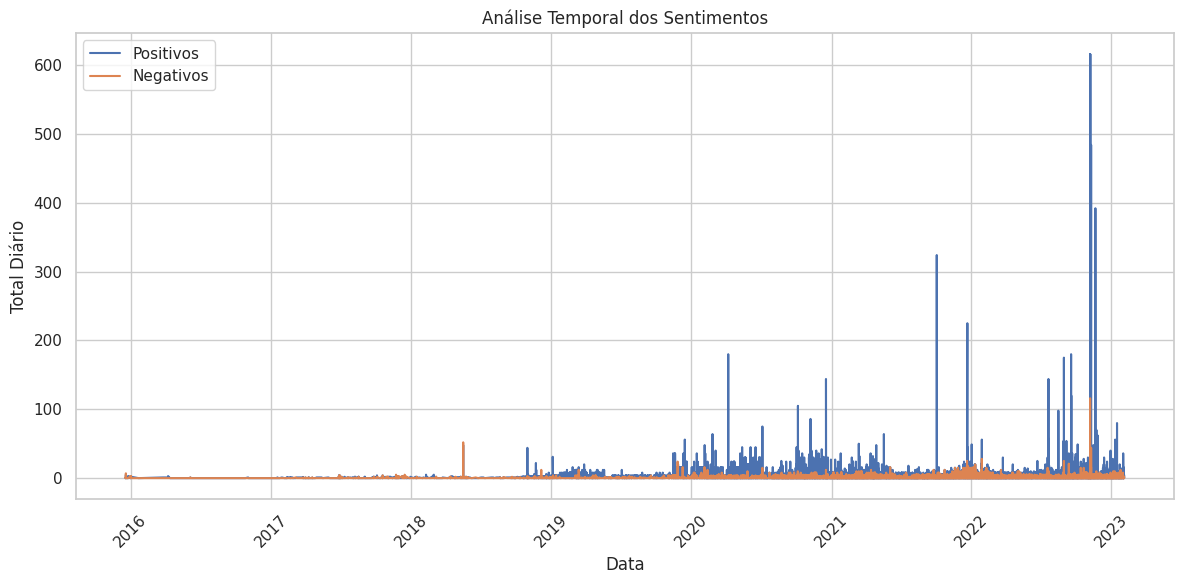

In [ ]:
plot_feelings_per_date(data_test_youtube)

In [ ]:
stopwords_list = [
    "de","a",  "o",  "que",
    "e",  "do", "da", "em",
    "um", "para",        "com","não",
    "uma","os", "no", "se",
    "na", "por","mais",        "as",
    "dos","como",        "mas","ao",
    "ele","das","à",  "seu",
    "sua","ou", "quando",      "muito",
    "nos","já", "eu", "também",
    "só", "pelo",        "pela",        "até",
    "isso",        "ela","entre",       "depois",
    "sem","mesmo",       "aos","seus",
    "quem",        "nas","me", "esse",
    "eles",        "você",        "essa",        "num",
    "nem","suas",        "meu","às",
    "minha",       "numa",        "pelos",       "elas",
    "qual",        "nós","lhe","deles",
    "essas",       "esses",       "pelas",       "este",
    "dele",        "tu", "te", "vocês",
    "vos","lhes",        "meus",        "minhas",
    "teu","tua","teus",        "tuas",
    "nosso",       "nossa",       "nossos",      "nossas",
    "dela",        "delas",       "esta",        "estes",
    "estas",       "aquele",      "aquela",      "aqueles",
    "aquelas",     "isto",        "aquilo",      "estou",
    "está",        "estamos",     "estão",       "estive",
    "esteve",      "estivemos",   "estiveram",   "estava",
    "estávamos",   "estavam",     "estivera",    "estivéramos",
    "esteja",      "estejamos",   "estejam",     "estivesse",
    "estivéssemos","estivessem",  "estiver",     "estivermos",
    "estiverem",   "hei","há", "havemos",
    "hão","houve",       "houvemos",    "houveram",
    "houvera",     "houvéramos",  "haja",        "hajamos",
    "hajam",       "houvesse",    "houvéssemos", "houvessem",
    "houver",      "houvermos",   "houverem",    "houverei",
    "houverá",     "houveremos",  "houverão",    "houveria",
    "houveríamos", "houveriam",   "sou","somos",
    "são","era","éramos",      "eram",
    "fui","foi","fomos",       "foram",
    "fora",        "fôramos",     "seja",        "sejamos",
    "sejam",       "fosse",       "fôssemos",    "fossem",
    "for","formos",      "forem",       "serei",
    "será",        "seremos",     "serão",       "seria",
    "seríamos",    "seriam",      "tenho",       "tem",
    "temos",       "tém","tinha",       "tínhamos",
    "tinham",      "tive",        "teve",        "tivemos",
    "tiveram",     "tivera",      "tivéramos",   "tenha",
    "tenhamos",    "tenham",      "tivesse",     "tivéssemos",
    "tivessem",    "tiver",       "tivermos",    "tiverem",
    "terei",       "terá",        "teremos",     "terão",
    "teria",       "teríamos",    "teriam", "pra",
    "fala", "disse", "diz", "vai", "é", "the", "la", "and",
    "to", "en", "el", "of", "voc", "dr",
    "canal", "oficial", "via", "video", "vídeo", "vdeo", "grupo",
    "3"
]

link_domain = [
    "http", "https", "www", "br", "com", "link", "html",
    "youtu", "be", "youtube", "shorts", "share", "org",
    "watch", "m", "bit", "ly", "link", "t", "v", "y", "j", "est",
    "instagram", "facebook", "telegram", "bitchute", "rumble", 'odysee'
    "feature", "bitslide", "twitter", "9gsjokvqtuk" , "s", "r"
]

except_list = stopwords_list + link_domain

In [ ]:
def generate_word_cloud(df, feeling, except_list, top_n):
    df_filtered = df[df['predicted_feeling'] == feeling]

    all_messages = ' '.join(df_filtered['message_data'].dropna().astype(str).str.lower())

    # Criar a nuvem de palavras
    wordcloud = WordCloud(stopwords=except_list,
                          normalize_plurals = True,
                          width = 800,
                          height = 400,
                          background_color = 'white',
                          min_font_size = 25,
                          max_words=top_n).generate(all_messages)

    # Display the generated image:
    fig, ax = plt.subplots(figsize = (10, 6))
    plt.title(f"TOP {top_n} palavras de sentimentos {feeling}s")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

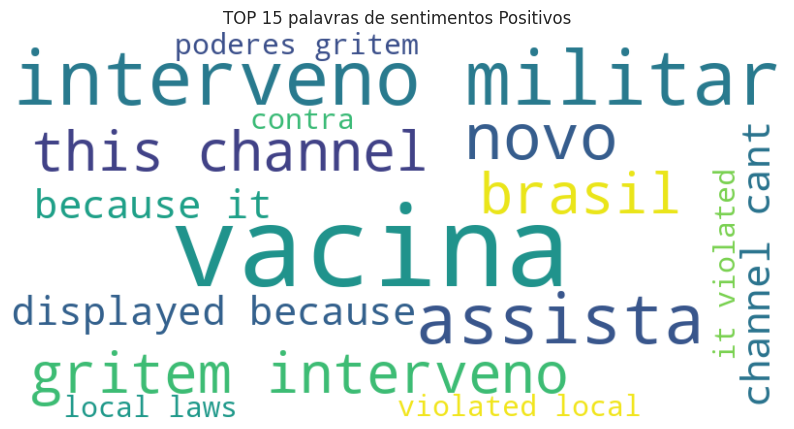

In [ ]:
generate_word_cloud(data_test_youtube, 'Positivo', except_list, 15)

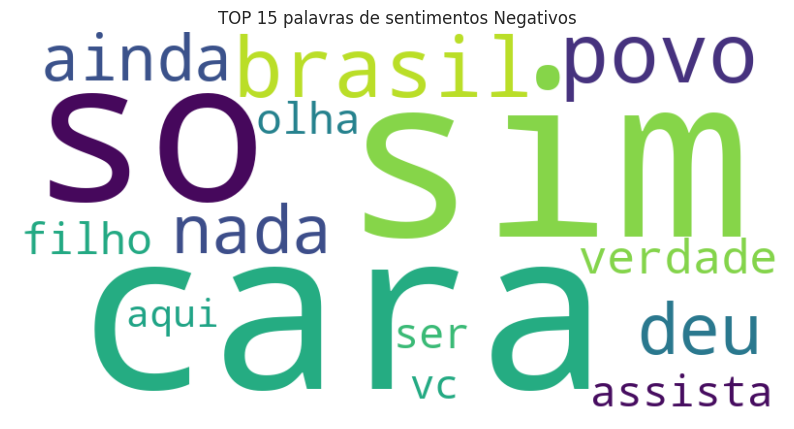

In [ ]:
generate_word_cloud(data_test_youtube, 'Negativo', except_list, 15)

In [ ]:
def plot_word_frequency(data_frame, feeling_filter, except_list, top_n):
    filtered_data = data_frame[data_frame['predicted_feeling'] == feeling_filter]

    all_messages = ' '.join(filtered_data['message_data'].dropna().astype(str).str.lower())

    # Tokenizar as palavras
    words = word_tokenize(all_messages)

    # Remover stopwords
    stop_words = set(stopwords.words('english'))
    stop_words.update(except_list)
    words = [word for word in words if word.isalnum() and word not in stop_words]

    # Calcular a frequência das palavras
    freq_dist = FreqDist(words)

    # Plotar o gráfico de frequência das palavras
    freq_dist.plot(top_n, cumulative = False)
    plt.show()

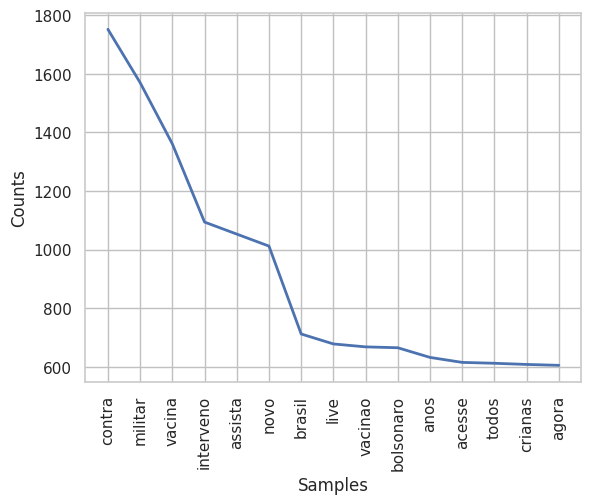

In [ ]:
plot_word_frequency(data_test_youtube, 'Positivo', except_list, 15)

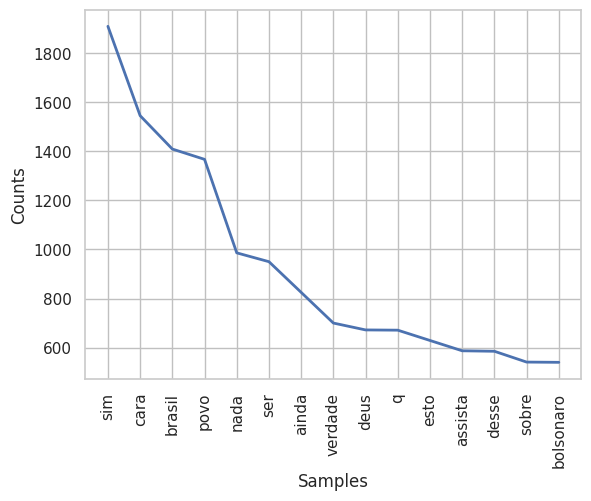

In [ ]:
plot_word_frequency(data_test_youtube, 'Negativo', except_list, 15)